# UE Computer Vision | Project : Visual tracking of video objects
# Results scoring

In [25]:
import numpy as np
import glob
from tqdm import tqdm
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
from skimage.measure import regionprops

In [50]:
#Params
sequence_name = "bear"
methods_raw = ["HS", "LK", "Fa", "raft"]
methods_tested = []
for method in methods_raw:
    methods_tested.append("direct-"+method)
    methods_tested.append("direct-"+method+"-post")
    methods_tested.append("seq-"+method)
    methods_tested.append("seq-"+method+"-post")
#methods_tested = ["seq-LK-old", "seq-LK"]
save_gifs = False
save_metrics = False

#Params for full scoring
compute_mean_scores = True
table_scoring_sequences = ["bag", "bear", "book", "camel", "rhino", "swan"]

In [27]:
#get number frames
files = glob.glob("data/sequences-train/"+sequence_name+"-*.png")
im_begin = 1
im_end = len(files)

Let us visualize some images with associated groundtruth masks.

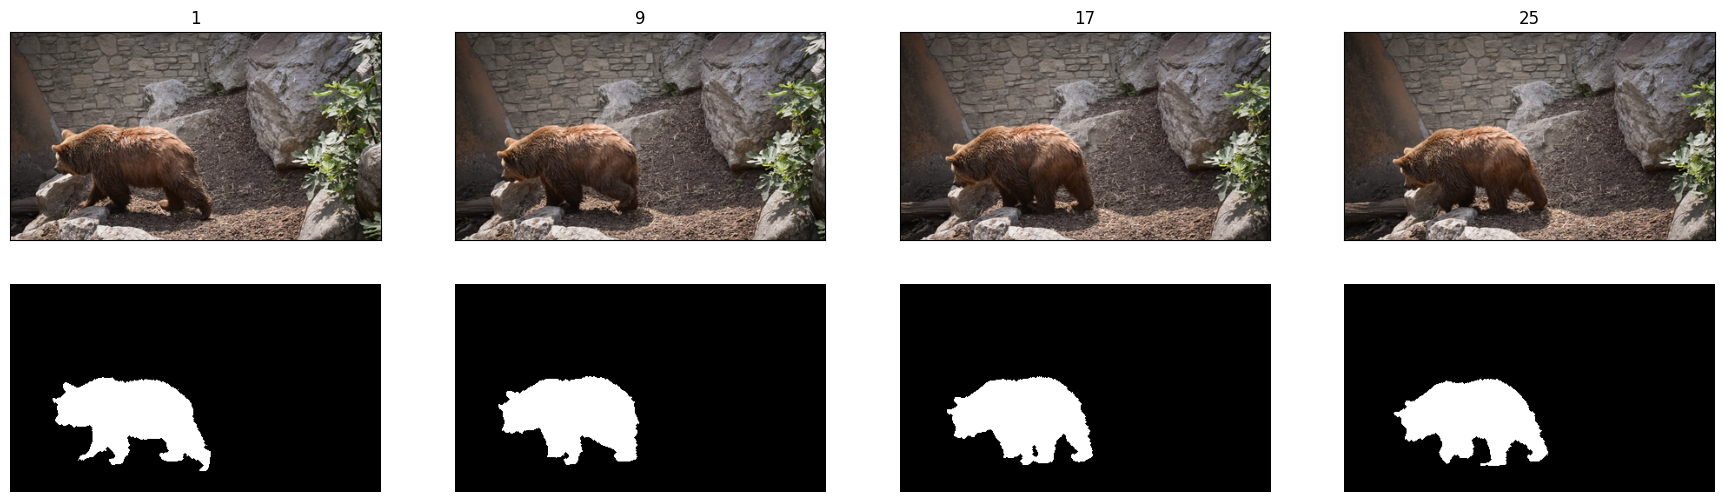

In [28]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([i for i in range(1, im_end, int(im_end/3.))]):
    img_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im))
    mask_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The `dice_assessment()`, `db_eval_boundary()` and `centroid_assessment()` functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object. 

`dice_assessment()` evaluates the overlap between the two masks while `db_eval_boundary()` quantifies the quality of the estimated contours. Each function returns a score between 0% (poor quality) and 100% (perfect quality).

`centroid_assessment()` comptes the *Euclidean* distance between groundtruth and estimated centroids.

In [29]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [30]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [31]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

In [32]:
img_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im_begin))

results = {}
for method in methods_tested:
    dices, fmeasures, centroid_dist, visu = [], [], [], []
    print("Computing scores for", method)
    for im in tqdm(range(im_begin+1,im_end+1)):
        img_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im))
        mask_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im))

        mask_computed = io.imread("data/mask-outputs/"+method+"_"+sequence_name+'/%0*d.png'%(3,im))
        visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), mask_computed, color=(1,0,0)))
        dices.append(dice_assessment(mask_current, mask_computed))
        fmeasures.append(db_eval_boundary(mask_current, mask_computed))
        centroid_dist.append(centroid_assessment(mask_current, mask_computed))

    result_method = {"dices": dices, "fmeasures": fmeasures, "centroid_dist": centroid_dist, "visu": visu}
    results[method] = result_method

Computing scores for direct-HS


100%|██████████| 25/25 [00:01<00:00, 17.02it/s]


Computing scores for direct-HS-post


100%|██████████| 25/25 [00:01<00:00, 14.95it/s]


Computing scores for seq-HS


100%|██████████| 25/25 [00:01<00:00, 24.32it/s]


Computing scores for seq-HS-post


100%|██████████| 25/25 [00:01<00:00, 18.27it/s]


Computing scores for direct-LK


100%|██████████| 25/25 [00:01<00:00, 22.42it/s]


Computing scores for direct-LK-post


100%|██████████| 25/25 [00:01<00:00, 24.08it/s]


Computing scores for seq-LK


100%|██████████| 25/25 [00:01<00:00, 24.69it/s]


Computing scores for seq-LK-post


100%|██████████| 25/25 [00:01<00:00, 21.57it/s]


Computing scores for direct-Fa


100%|██████████| 25/25 [00:01<00:00, 24.02it/s]


Computing scores for direct-Fa-post


100%|██████████| 25/25 [00:01<00:00, 23.06it/s]


Computing scores for seq-Fa


100%|██████████| 25/25 [00:01<00:00, 22.38it/s]


Computing scores for seq-Fa-post


100%|██████████| 25/25 [00:01<00:00, 20.79it/s]


Computing scores for direct-raft


100%|██████████| 25/25 [00:01<00:00, 19.60it/s]


Computing scores for direct-raft-post


100%|██████████| 25/25 [00:01<00:00, 21.72it/s]


Computing scores for seq-raft


100%|██████████| 25/25 [00:01<00:00, 15.78it/s]


Computing scores for seq-raft-post


100%|██████████| 25/25 [00:01<00:00, 17.94it/s]


## Results visualization

Once your method is implemented, you will be able to display the evolution of dice, F-measure scores and distance between centroids along the video sequences...

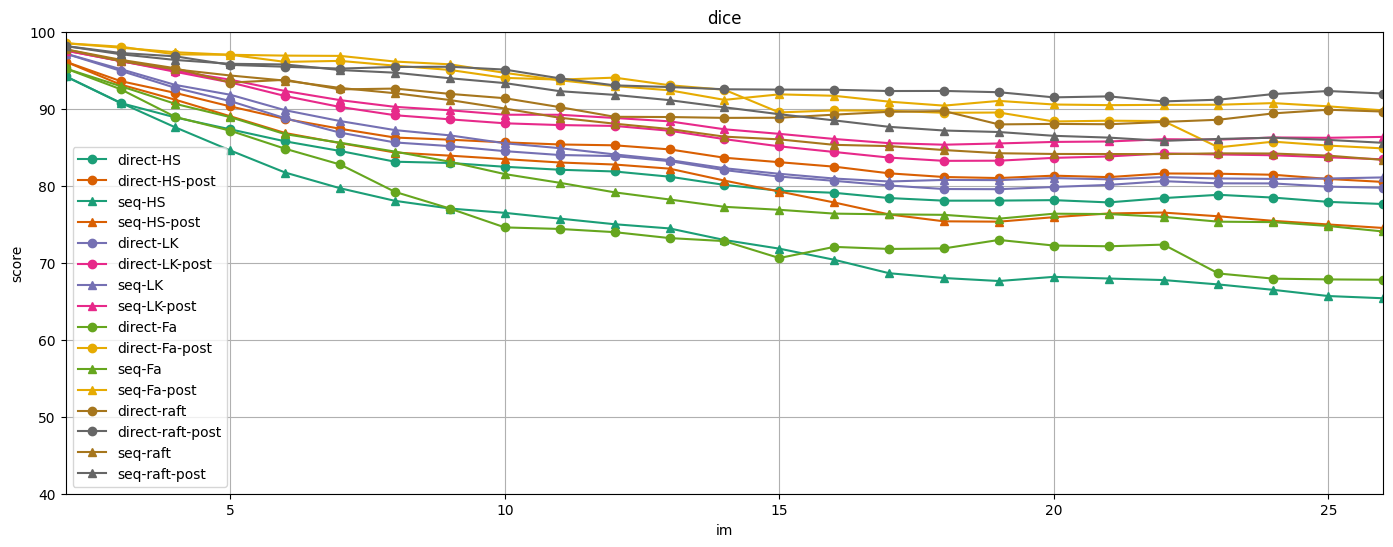

In [33]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["dices"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["dices"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["dices"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["dices"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))

plt.xlim((im_begin+1,im_end))
plt.ylim((40,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title("dice")
plt.show()

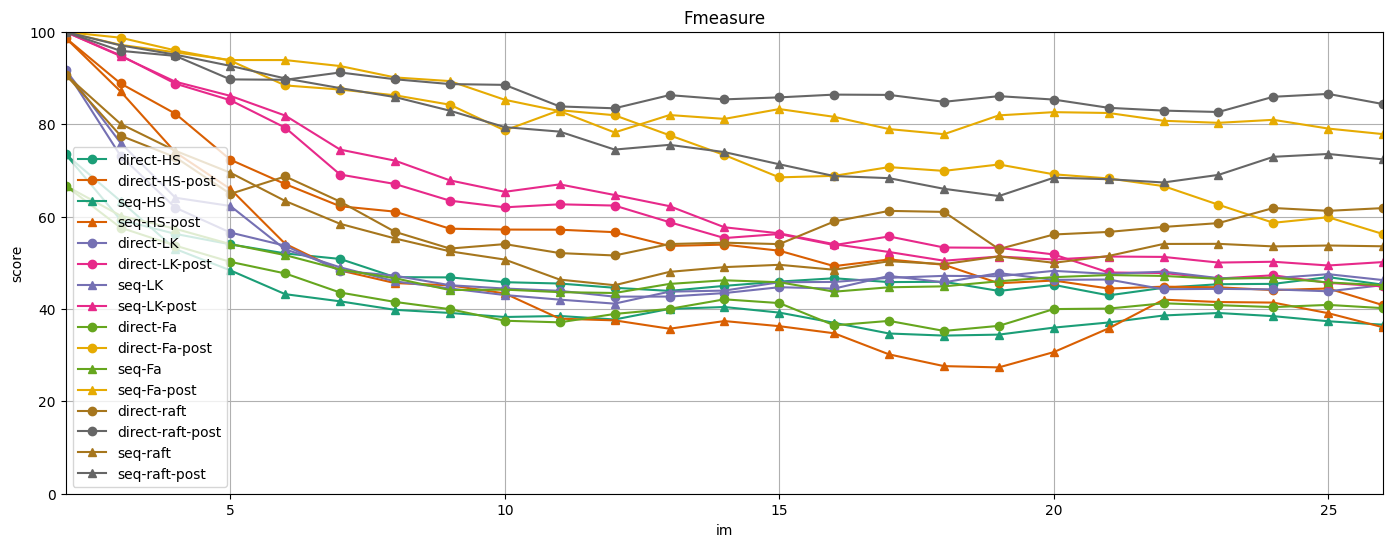

In [34]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["fmeasures"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["fmeasures"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["fmeasures"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["fmeasures"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))

plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title('Fmeasure')
plt.show()

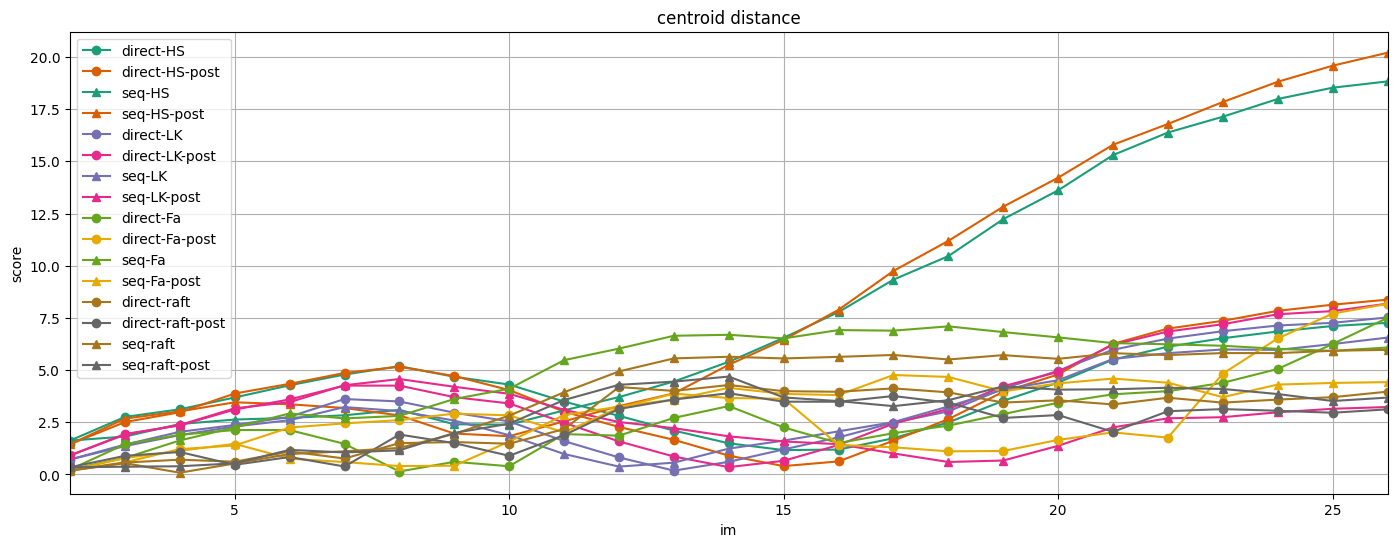

In [35]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["centroid_dist"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["centroid_dist"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["centroid_dist"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["centroid_dist"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title('centroid distance')
plt.show()

... and view the obtained **tracking results** (ground truth in green, estimated contours in red) !

In [36]:
if save_gifs:
    import imageio
    for method in methods_tested:
        with imageio.get_writer("data/gif-outputs/"+sequence_name+method+'.gif', mode='I') as writer:
            for image in results[method]["visu"]:
                image = img_as_ubyte(image)
                writer.append_data(image)

In [37]:
if save_metrics:
    for method in methods_tested:
        np.save("team1-"+sequence_name+"-dices.npy", results[method]["dices"])
        np.save("team1-"+sequence_name+"-fmeasures.npy", results[method]["fmeasures"])
        np.save("team1-"+sequence_name+"-centroids.npy", results[method]["centroid_dist"])

# Full Table Results scoring

In [74]:
def plot_transposed_table_with_max(table, title):
    table_t = table.transpose()
    styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'white')])]
    return table_t.style.highlight_max(color = 'green', axis = 0).set_caption(title).set_table_styles(styles)
def plot_transposed_table_with_min(table, title):
    table_t = table.transpose()
    styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "150%"),
                              ("color", 'white')])]
    return table_t.style.highlight_min(color = 'green', axis = 0).set_caption(title).set_table_styles(styles)

In [51]:
if compute_mean_scores:
    import pandas as pd

    full_scores_dices_table = pd.DataFrame(columns=methods_tested)
    full_scores_fmeasures_table = pd.DataFrame(columns=methods_tested)
    full_scores_centroid_dist_table = pd.DataFrame(columns=methods_tested)

    for sequence_name in table_scoring_sequences:
        print("Computing all scores for", sequence_name)
        dices_sequence_results = {}
        fmeasures_sequence_results = {}
        centroid_dist_sequence_results = {}

        #get number frames
        files = glob.glob("data/sequences-train/"+sequence_name+"-*.png")
        im_begin = 1
        im_end = len(files)

        img_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im_begin))
        mask_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im_begin))

        results = {}
        for method in methods_tested:
            dices, fmeasures, centroid_dist, visu = [], [], [], []
            for im in tqdm(range(im_begin+1,im_end+1), desc=method):
                img_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im))
                mask_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im))

                mask_computed = io.imread("data/mask-outputs/"+method+"_"+sequence_name+'/%0*d.png'%(3,im))
                dices.append(dice_assessment(mask_current, mask_computed))
                fmeasures.append(db_eval_boundary(mask_current, mask_computed))
                centroid_dist.append(centroid_assessment(mask_current, mask_computed))

            dices_sequence_results[method] = np.array(dices).mean()
            fmeasures_sequence_results[method] = np.array(fmeasures).mean()
            centroid_dist_sequence_results[method] = np.array(centroid_dist).mean()

        full_scores_dices_table.loc[sequence_name] = dices_sequence_results
        full_scores_fmeasures_table.loc[sequence_name] = fmeasures_sequence_results
        full_scores_centroid_dist_table.loc[sequence_name] = centroid_dist_sequence_results

Computing all scores for bag


seq-raft-post: 100%|██████████| 195/195 [00:12<00:00, 15.80it/s]


Computing all scores for bear


seq-raft-post: 100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Computing all scores for book


seq-raft-post: 100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Computing all scores for camel


seq-raft-post: 100%|██████████| 89/89 [00:02<00:00, 33.36it/s]


Computing all scores for rhino


seq-raft-post: 100%|██████████| 89/89 [00:02<00:00, 29.99it/s]


Computing all scores for swan


seq-raft-post: 100%|██████████| 49/49 [00:01<00:00, 26.71it/s]


## Dice scores

In [70]:
plot_transposed_table_with_max(full_scores_dices_table, title="Mean dice score for all sequences and methods")

,bag,bear,book,camel,rhino,swan
direct-HS,3.424437,81.811080,0.592159,58.009814,74.178237,63.212496
direct-HS-post,3.220790,84.903213,0.578101,59.693986,77.665436,66.599424
seq-HS,2.763856,74.530116,0.592159,47.093918,56.335776,50.973748
seq-HS-post,3.043912,81.438274,0.578101,54.287763,61.927350,60.317606
direct-LK,3.753179,84.059238,0.650687,59.076014,75.208378,67.937926
direct-LK-post,3.918678,87.397204,0.664928,63.188492,78.796729,71.137102
seq-LK,3.043757,84.820415,0.668871,65.061630,73.489268,74.808297
seq-LK-post,3.663308,88.809729,0.684356,66.999558,78.349556,76.286401
direct-Fa,4.018607,76.188786,1.192322,56.217892,66.317852,80.977509
direct-Fa-post,4.987876,91.793709,1.471898,68.809105,83.368890,92.326083


In [84]:
full_scores_dices_table.mean(axis=0).sort_values()

seq-HS              38.714929
seq-HS-post         43.598834
direct-HS           46.871370
direct-Fa           47.485495
direct-LK           48.447570
direct-HS-post      48.776825
seq-LK              50.315373
seq-Fa              50.532661
direct-LK-post      50.850522
seq-LK-post         52.465485
direct-Fa-post      57.126260
seq-Fa-post         60.507296
seq-raft            64.279375
seq-raft-post       67.198477
direct-raft         67.964688
direct-raft-post    69.813336
dtype: float64

## F-measure scores

In [71]:
plot_transposed_table_with_max(full_scores_fmeasures_table, title="Mean F-measure score for all sequences and methods")

,bag,bear,book,camel,rhino,swan
direct-HS,2.613230,48.319851,0.666300,32.295488,31.254125,44.968494
direct-HS-post,3.212754,57.008488,0.582511,25.452941,32.338834,35.969225
seq-HS,2.248215,41.574769,0.610183,26.598333,30.165355,40.387776
seq-HS-post,1.484711,45.322997,0.475290,24.416518,21.904741,32.232284
direct-LK,2.530506,49.554366,0.845273,33.644523,38.953046,45.040138
direct-LK-post,1.837491,62.108277,0.550259,31.576153,34.003710,40.232930
seq-LK,2.449365,50.548148,1.296524,39.608100,37.068441,51.931523
seq-LK-post,1.896465,64.026561,1.575606,37.805979,37.816539,43.591561
direct-Fa,3.956085,42.662208,2.020619,37.236241,39.175725,62.089709
direct-Fa-post,4.192595,76.777871,2.083212,47.665751,56.420370,86.773150


In [82]:
full_scores_fmeasures_table.mean(axis=0).sort_values()

seq-HS-post         20.972757
seq-HS              23.597438
direct-HS-post      25.760792
direct-HS           26.686248
direct-LK-post      28.384803
direct-LK           28.427975
seq-LK              30.483684
seq-LK-post         31.118785
direct-Fa           31.190098
direct-Fa-post      45.652158
seq-raft            45.977401
seq-Fa              46.822397
direct-raft         50.240357
seq-raft-post       55.475996
seq-Fa-post         60.925703
direct-raft-post    61.254940
dtype: float64

## Centroid distances

In [73]:
plot_transposed_table_with_min(full_scores_centroid_dist_table, title="Mean centroid distance for all sequences and methods")

,bag,bear,book,camel,rhino,swan
direct-HS,143.877685,3.929358,93.055758,19.711161,13.426502,14.250258
direct-HS-post,145.106463,4.031946,92.640352,19.408971,13.846521,14.952831
seq-HS,152.472115,8.107756,98.127561,35.780862,30.543608,18.181718
seq-HS-post,151.188602,8.403905,99.318241,41.541580,32.434598,19.534751
direct-LK,145.140176,3.359702,93.834473,19.373337,12.794067,13.550590
direct-LK-post,145.006261,3.742127,94.049734,19.305535,13.487552,12.910246
seq-LK,142.473453,3.076722,88.972343,9.977873,9.264354,10.266278
seq-LK-post,143.560492,2.485613,88.816698,8.040057,12.944365,10.289691
direct-Fa,144.801444,2.627269,98.137128,18.523283,9.058599,2.858570
direct-Fa-post,145.963349,2.817703,96.934862,19.283920,9.702700,2.861960


In [83]:
full_scores_centroid_dist_table.mean(axis=0).sort_values()

seq-Fa              24.123282
seq-Fa-post         24.408011
seq-raft            25.379639
direct-raft-post    26.599595
direct-raft         26.617944
seq-raft-post       26.983979
seq-LK              44.005170
seq-LK-post         44.356153
direct-Fa           46.001049
direct-Fa-post      46.260749
direct-LK           48.008724
direct-HS           48.041787
direct-LK-post      48.083576
direct-HS-post      48.331180
seq-HS              57.202270
seq-HS-post         58.736946
dtype: float64